In [99]:
%load_ext autoreload
%autoreload 2

import sklearn.linear_model as linear_model
import random
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

import pandas as pd
from src.visuals import plot_roc
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import copy

from src.relevance_network import compute_mutual_info_matrix
from src.visuals import plot_corr_and_mi_matrices
from src.visuals import plot_relevance_graph
from matplotlib import pyplot as plt
from ipywidgets import interact

from src.visuals import plot_roc, plot_roc_simplified
from src.commons import calculate_confusion_matrix_from_model, apply_threshold

import pysindy as ps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_fpr_tpr(true_structure, predictions):
    # compute tpr and fpr using sklearn
    fpr, tpr, thresholds = roc_curve(true_structure, predictions)
    roc_auc = auc(fpr, tpr)
    # compute actual fps and tps
    fps, tps = [], []
    for th in thresholds:
        cf = confusion_matrix(true_structure, predictions>=th)
        fps.append(cf[0,1])
        tps.append(cf[1,1])
    
    return fpr, tpr, fps, tps, thresholds, roc_auc

In [4]:
seed = 2

In [5]:
# read from txt file to pandas
data_path = 'data/data.txt'
data = pd.read_csv(data_path, sep=' ', header=0)
data.values

array([[0.076 , 0.0419, 0.0207, 0.0225, 0.1033],
       [0.0186, 0.0365, 0.0122, 0.0175, 0.0462],
       [0.009 , 0.0514, 0.0073, 0.0165, 0.0439],
       [0.0117, 0.0473, 0.0079, 0.0147, 0.0371],
       [0.0088, 0.0482, 0.0084, 0.0145, 0.0475],
       [0.0095, 0.0546, 0.01  , 0.0144, 0.0468],
       [0.0075, 0.0648, 0.0096, 0.0106, 0.0347],
       [0.007 , 0.0552, 0.0107, 0.0119, 0.0247],
       [0.0081, 0.0497, 0.0113, 0.0104, 0.0269],
       [0.0057, 0.0352, 0.0116, 0.0142, 0.019 ],
       [0.0052, 0.0358, 0.0073, 0.0084, 0.0134],
       [0.0093, 0.0338, 0.0075, 0.0097, 0.0148],
       [0.0055, 0.0309, 0.0082, 0.0088, 0.0101],
       [0.006 , 0.0232, 0.0078, 0.0087, 0.0088],
       [0.0069, 0.0191, 0.0089, 0.0086, 0.008 ],
       [0.0093, 0.019 , 0.0104, 0.011 , 0.009 ],
       [0.009 , 0.0176, 0.0114, 0.0124, 0.0113],
       [0.0129, 0.0105, 0.01  , 0.0093, 0.0154],
       [0.0022, 0.0081, 0.0086, 0.0079, 0.003 ],
       [0.0018, 0.0072, 0.0078, 0.0103, 0.0012]])

In [6]:
# get data in shape for training: use observations from t=0 to predict t=1, resulting in pairs of observations \delta_t apart
X = data.iloc[:-1]
Y = data.iloc[1:]

In [7]:
gene_names = list(data.columns.values)
model_true_model = {
    'SWI5': [None, 1, 0, 1, 1],
    'CBF1': [0, None, 1, 0, 0],
    'GAL4': [1, 0, None, 0, 0],
    'GAL80': [0, 0, 0, None, 0],
    'ASH1': [0, -1, 0, 0, None]
}
model_true = pd.DataFrame(model_true_model, index=gene_names)
true_structure = (model_true.fillna(0)!=0).values.flatten()
true_structure

array([False, False,  True, False, False,  True, False, False, False,
        True, False,  True, False, False, False,  True, False, False,
       False, False,  True, False, False, False, False])

# Relevance networks

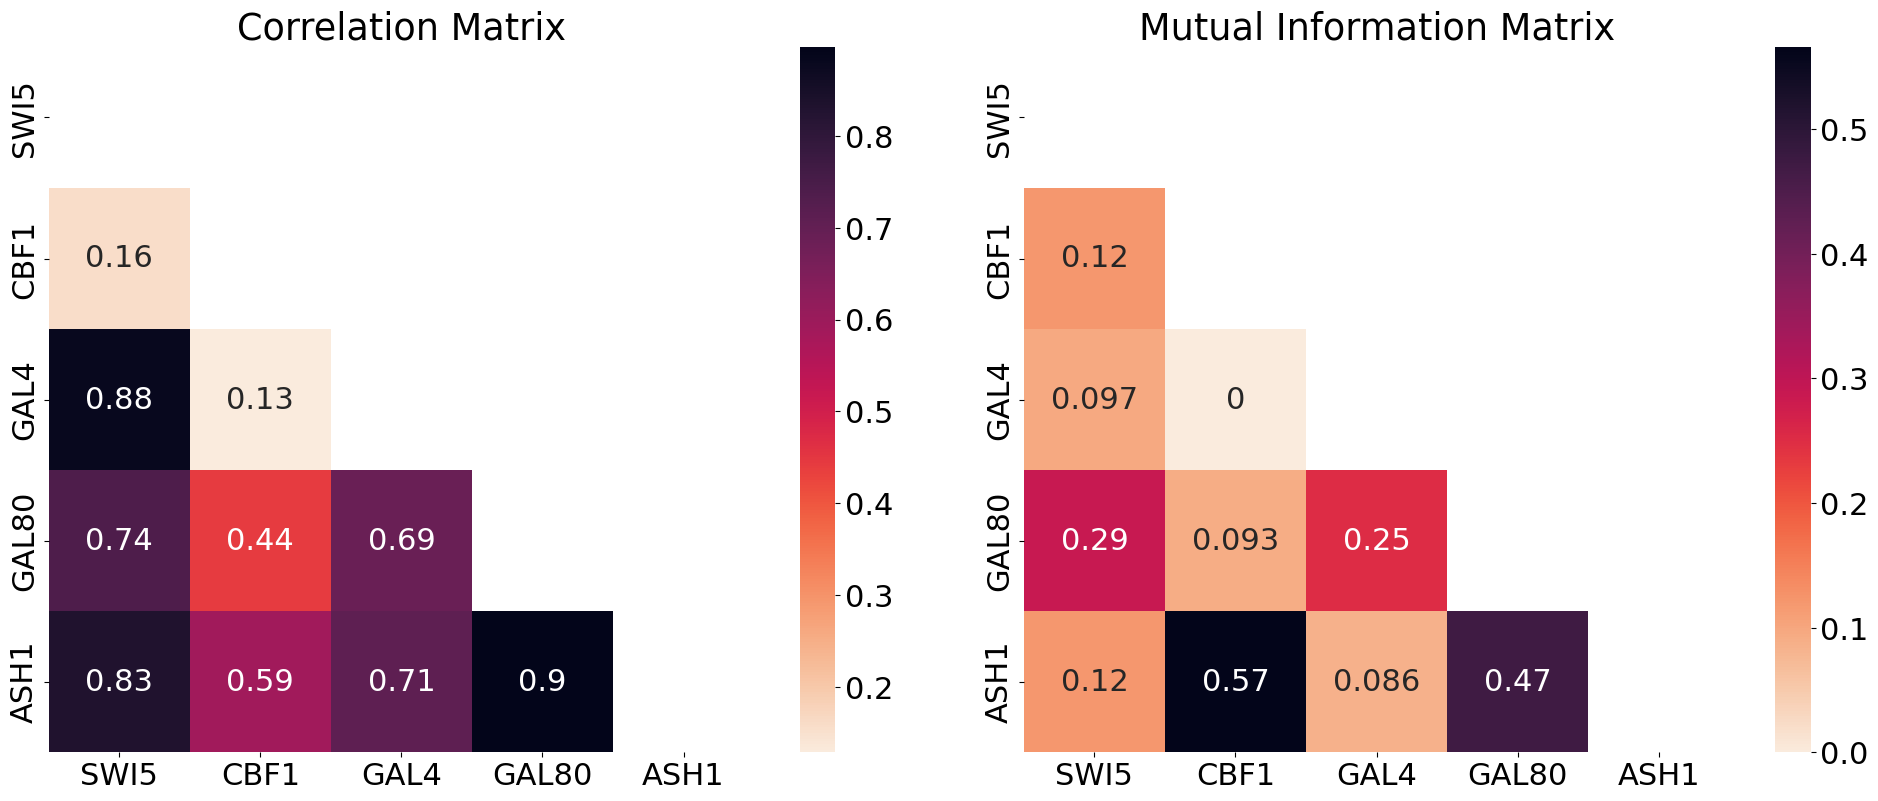

In [100]:
"""Sets the seed for reproducibility."""
random.seed(seed)  # Python random module
np.random.seed(seed)  # Numpy module
torch.manual_seed(seed)  # PyTorch
os.environ['PYTHONHASHSEED'] = str(seed)  # Python hash seed

# Calculate correlation matrix
correlation_matrix = data.corr()
mi_matrix = compute_mutual_info_matrix(data)

matplotlib.rcParams.update({'font.size': 22})
plot_corr_and_mi_matrices(correlation_matrix, mi_matrix)

In [76]:
@interact(threshold=(0.0, 1.0))
def widget_plot(threshold):
    fig, axs = plt.subplots(1, 2, figsize=(16, 7))  # Create a figure with two subplots

    plot_relevance_graph(axs[0], threshold, mi_matrix, "Mutual Information Graph")
    plot_relevance_graph(axs[1], threshold, correlation_matrix, "Correlation Graph")

    plt.show()


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0), Output()), _dom_classes=('widg…

all_true_idx 7, min_th 0.0, tpr 1.0, fpr 1.0, fps 19, tps 6 



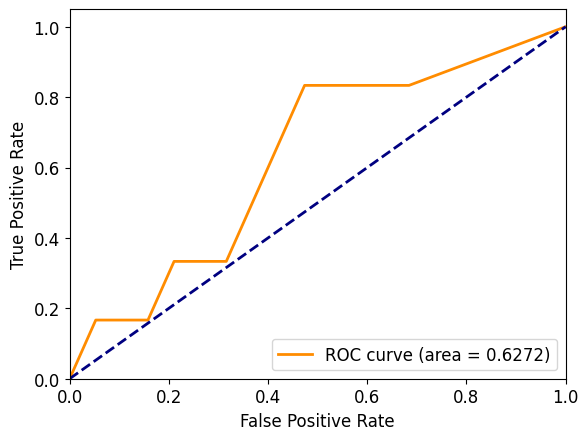

In [105]:
# process the coefficients to get the network structure as binary predictions
matplotlib.rcParams.update({'font.size': 12})
weights = copy.deepcopy(mi_matrix.values)
weights[range(5), range(5)] = 0
predictions = np.abs(weights.flatten())

fpr, tpr, fps, tps, thresholds, roc_auc = get_fpr_tpr(true_structure, predictions)
# get the minimum threshold that gives all true positives
all_true_idx = np.where(tpr==1)[0].min()
print(f'all_true_idx {all_true_idx}, min_th {thresholds[all_true_idx]}, tpr {tpr[all_true_idx]}, fpr {fpr[all_true_idx]}, fps {fps[all_true_idx]}, tps {tps[all_true_idx]} \n')
plot_roc(fpr, tpr, roc_auc, save_path=f'figures/rn_mi_roc.png')
    

all_true_idx 6, min_th 0.12921319242854534, tpr 1.0, fpr 0.7368421052631579, fps 14, tps 6 



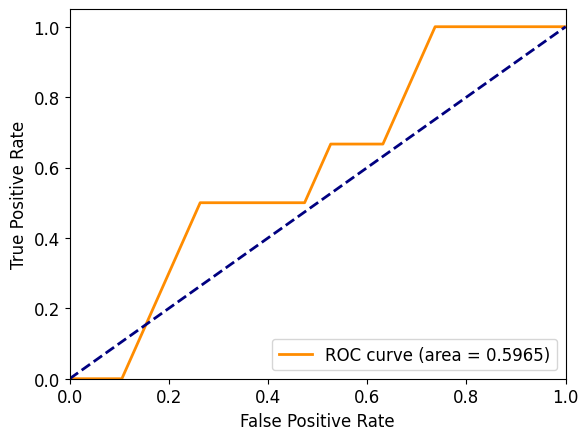

In [104]:

# process the coefficients to get the network structure as binary predictions
matplotlib.rcParams.update({'font.size': 12})
weights = copy.deepcopy(correlation_matrix.values)
weights[range(5), range(5)] = 0
predictions = np.abs(weights.flatten())

fpr, tpr, fps, tps, thresholds, roc_auc = get_fpr_tpr(true_structure, predictions)
# get the minimum threshold that gives all true positives
all_true_idx = np.where(tpr==1)[0].min()
print(f'all_true_idx {all_true_idx}, min_th {thresholds[all_true_idx]}, tpr {tpr[all_true_idx]}, fpr {fpr[all_true_idx]}, fps {fps[all_true_idx]}, tps {tps[all_true_idx]} \n')
plot_roc(fpr, tpr, roc_auc, save_path=f'figures/rn_corr_roc.png')

In [79]:
fpr

array([0.        , 0.10526316, 0.26315789, 0.47368421, 0.52631579,
       0.63157895, 0.73684211, 1.        ])

In [80]:
tpr

array([0.        , 0.        , 0.5       , 0.5       , 0.66666667,
       0.66666667, 1.        , 1.        ])

# ODE - LR

alpha: 0.01

all_true_idx 9, min_th 0.0276153874848241, tpr 1.0, fpr 0.6842105263157895, fps 13, tps 6 



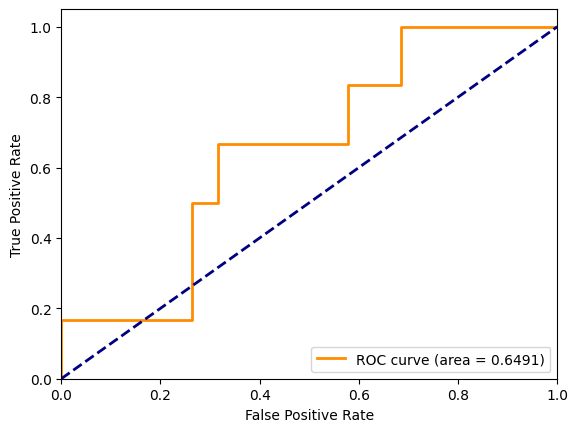

In [85]:
"""Sets the seed for reproducibility."""
random.seed(seed)  # Python random module
np.random.seed(seed)  # Numpy module
torch.manual_seed(seed)  # PyTorch
os.environ['PYTHONHASHSEED'] = str(seed)  # Python hash seed

alphas = np.linspace(0, 0.1, 10)
alphas = [0.01] # found empirically
for i, alpha in enumerate(alphas):
    print(f'alpha: {alpha}\n')
    lasso = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    out = lasso.fit(X,Y)
    coefficients = lasso.coef_

    # process the coefficients to get the network structure as binary predictions
    weights = copy.deepcopy(coefficients)
    weights[range(5), range(5)] = 0
    predictions = np.abs(weights.T.flatten())
    
    fpr, tpr, fps, tps, thresholds, roc_auc = get_fpr_tpr(true_structure, predictions)
    # get the minimum threshold that gives all true positives
    all_true_idx = np.where(tpr==1)[0].min()
    print(f'all_true_idx {all_true_idx}, min_th {thresholds[all_true_idx]}, tpr {tpr[all_true_idx]}, fpr {fpr[all_true_idx]}, fps {fps[all_true_idx]}, tps {tps[all_true_idx]} \n')

    plot_roc(fpr, tpr, roc_auc, save_path=f'figures/ode_lr_{alpha}.png')


# ODE - INT

In [9]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size, bias=False)
        
    def ode_function(self, t, x):
        return self.linear(x)
        
    def forward(self, x):
        # return self.linear(x)
        # define the forward function as an ODE
        t = torch.linspace(0, 10, 10)

        # Solve the ODE
        solution = odeint(self.ode_function, y0=x, t=t)
        
        return solution[-1]
   

alpha 0.01

Epoch 1, loss: 0.039292
mse 0.027439523488283157, L2 0.010124167427420616 

Epoch 501, loss: 0.000055
mse 4.302967499825172e-05, L2 1.1547776921361219e-05 

Epoch 1001, loss: 0.000055
mse 4.302972592995502e-05, L2 1.1547781468834728e-05 

Epoch 1501, loss: 0.000055
mse 4.302965317037888e-05, L2 1.1547776921361219e-05 

Epoch 2001, loss: 0.000057
mse 4.48133323516231e-05, L2 1.2339656677795574e-05 

Epoch 2501, loss: 0.000057
mse 4.489675848162733e-05, L2 1.223222443513805e-05 

all_true_idx 7, min_th 0.0013156768400222063, tpr 1.0, fpr 0.3684210526315789, fps 7, tps 6 



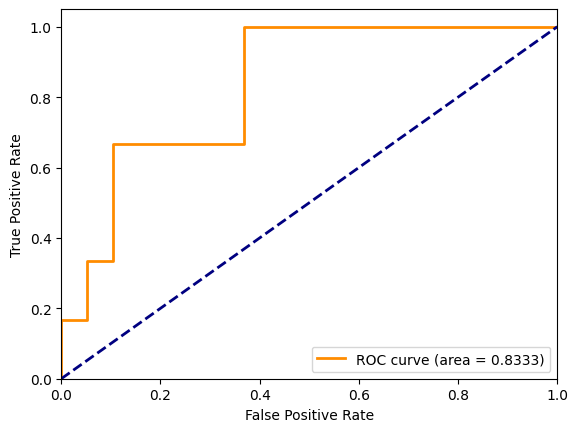

In [87]:
"""Sets the seed for reproducibility."""
random.seed(seed)  # Python random module
np.random.seed(seed)  # Numpy module
torch.manual_seed(seed)  # PyTorch
os.environ['PYTHONHASHSEED'] = str(seed)  # Python hash seed

class XYDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
dataset = XYDataset(X, Y)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

alphas = np.linspace(0, 1., 10)
alphas = [0.01]
for k, alpha in enumerate(alphas):
    print(f'alpha {alpha}\n')
    # define the training code
    #epochs = 4000
    epochs = 3000
    net = LinearModel(5, 5)  # +1 for time
    criterion = nn.MSELoss()
    #optimizer = optim.SGD(net.parameters(), lr=1., momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=1e-1)

    for epoch in range(epochs):
        for i, batch in enumerate(train_loader):
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels) + alpha * net.linear.weight.norm(2) ** 2
            loss.backward()
            optimizer.step()

        if epoch%500==0: 
            print('Epoch %d, loss: %.6f' % (epoch + 1, loss.item()))
            print(f'mse {criterion(outputs, labels)}, L2 {alpha * net.linear.weight.norm(2) ** 2} \n')

    weights = copy.deepcopy(net.linear.weight.detach().numpy())
    weights[range(5), range(5)] = 0
    predictions = np.abs(weights.T.flatten())
    
    fpr, tpr, fps, tps, thresholds, roc_auc = get_fpr_tpr(true_structure, predictions)
    # get the minimum threshold that gives all true positives
    all_true_idx = np.where(tpr==1)[0].min()
    print(f'all_true_idx {all_true_idx}, min_th {thresholds[all_true_idx]}, tpr {tpr[all_true_idx]}, fpr {fpr[all_true_idx]}, fps {fps[all_true_idx]}, tps {tps[all_true_idx]} \n')
    plot_roc(fpr, tpr, roc_auc, save_path=f'figures/ode_int_{alpha}.png')



preds_tensor torch.Size([20, 5])



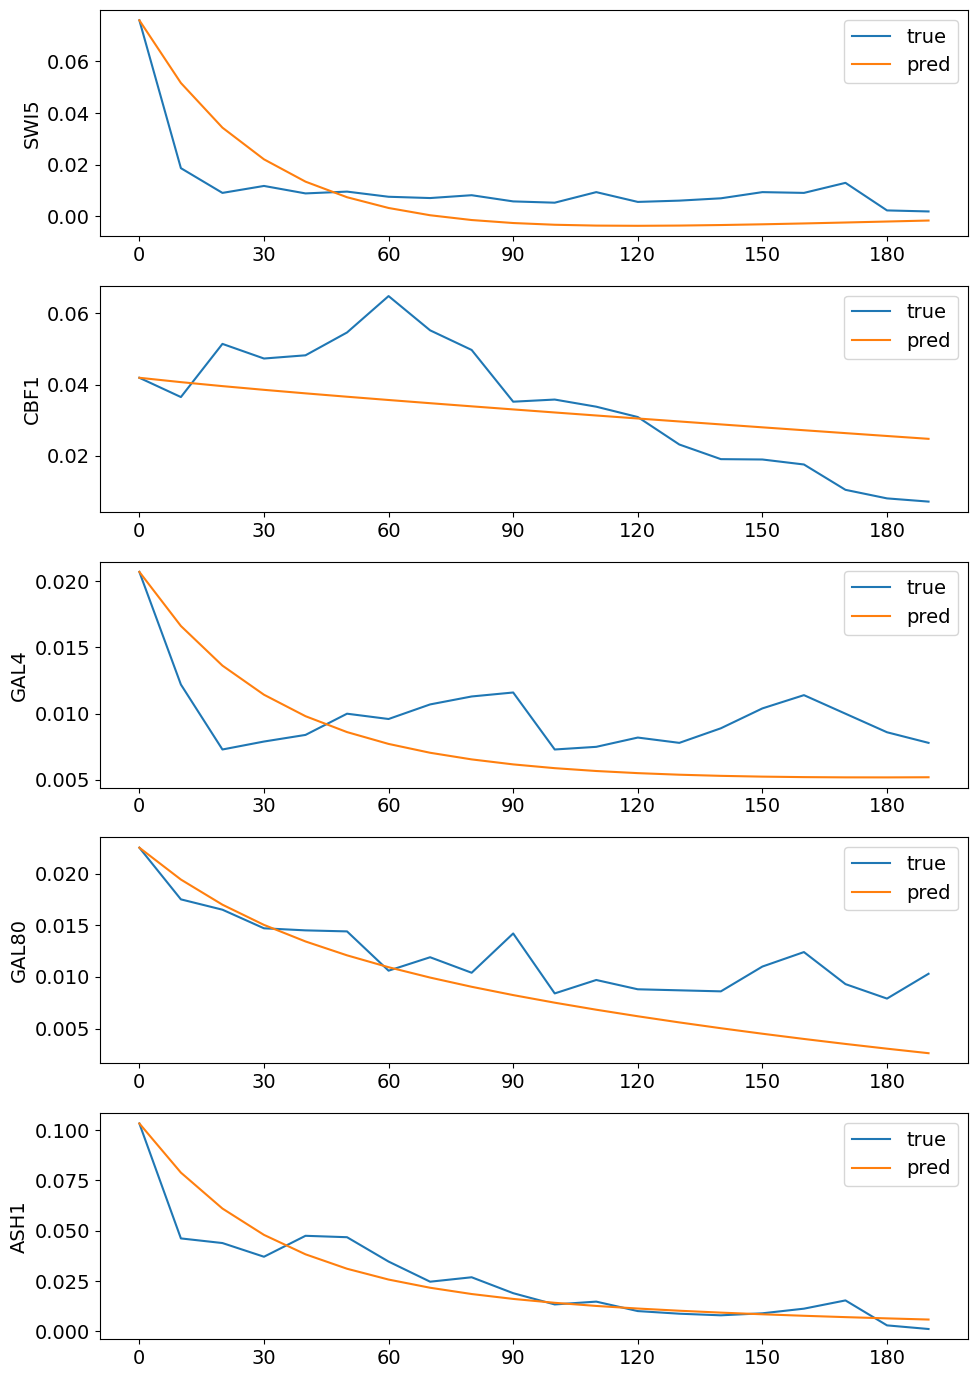

In [110]:
# plot predictions - predict full time series from initial point
matplotlib.rcParams.update({'font.size': 14})
net.eval()
all_preds = []
inp = torch.tensor(data.values[:1,:]).float()
all_preds.append(inp)

# iteratively integrate the ODE to get each next time step. 
# get values for 20 time steps
for i in range(1, 20):
    preds = net(inp)
    all_preds.append(preds)
    inp = preds.detach()

preds_tensor = torch.cat(all_preds, dim=0)
print(f'preds_tensor {preds_tensor.shape}\n')

total_ts = 20*10
t = [i for i in range(0, total_ts, 10)]
fig, axes = plt.subplots(5, 1, figsize=(10, 14))
for gene in range(5):
    axes[gene].plot(t, torch.tensor(data.values[:,gene]), label='true');
    axes[gene].set_xticks([t[i] for i in range(0, len(t), 3)]);
    axes[gene].set_ylabel(gene_names[gene])
    #print(f'preds_tensor[:,gene].detach().numpy() {preds_tensor[:,gene].detach().numpy().shape}\n')
    axes[gene].plot(t, preds_tensor[:,gene].detach().numpy(), label='pred');
    axes[gene].legend();
plt.tight_layout()
plt.savefig('figures/predictions_ode_int.png')

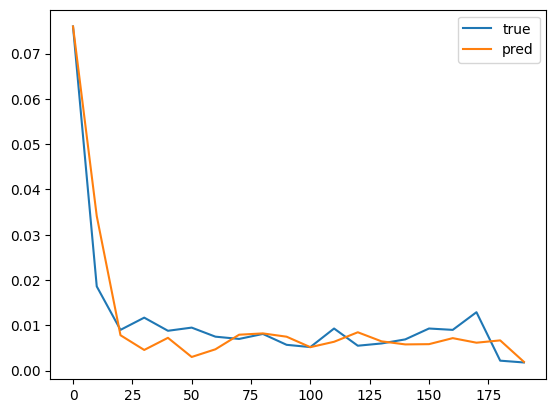

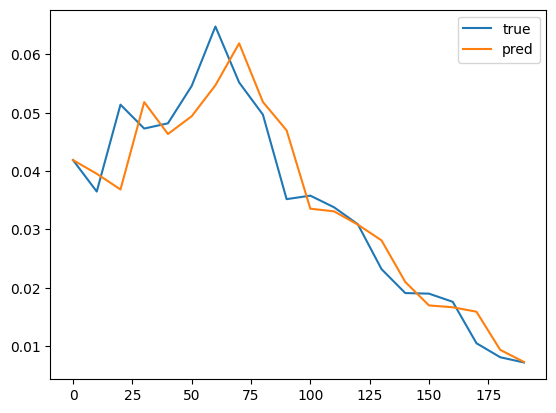

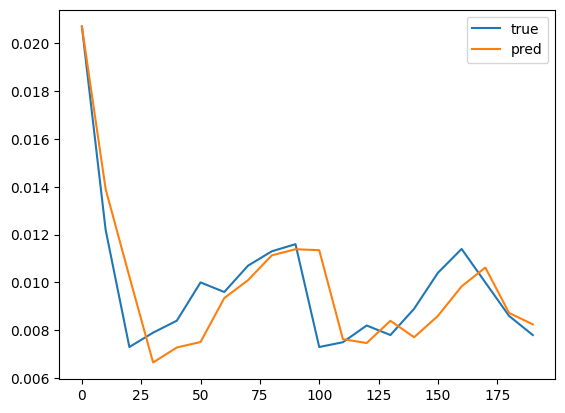

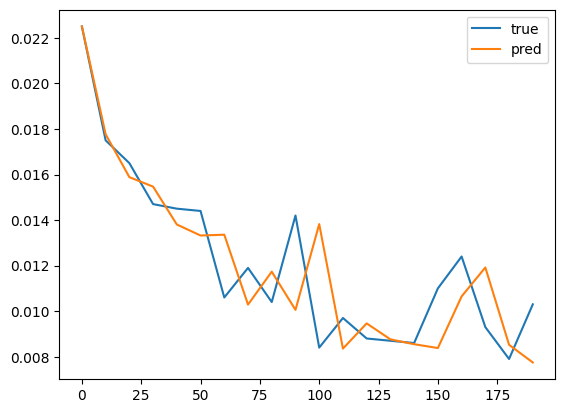

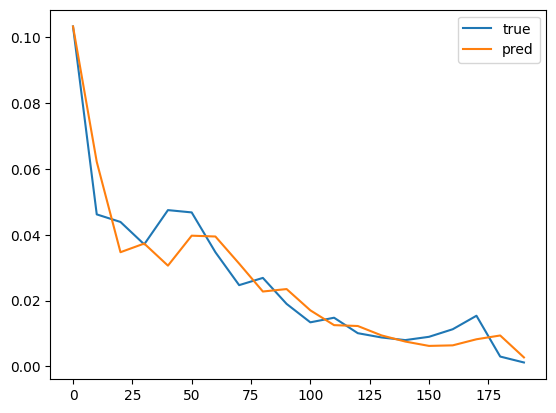

In [99]:
# plot predictions - one time point at a time
inp = torch.tensor(data.values[:-1])
first = torch.tensor(data.values[:1,:]).float()
pres_tensor = net(inp.float())
pres_tensor = torch.cat([first, pres_tensor[:,:]], dim=0)

total_ts = 20*10
t = [i for i in range(0, total_ts, 10)]
for gene in range(5):
    plt.figure()
    plt.plot(t, torch.tensor(data.values[:,gene]), label='true');
    #print(f'preds_tensor[:,gene].detach().numpy() {preds_tensor[:,gene].detach().numpy().shape}\n')
    plt.plot(t, pres_tensor[:,gene].detach().numpy(), label='pred');
    plt.legend();

# PySINDY

In [29]:
x_true = np.array(list(data.values)).T

In [31]:
# Sadly the data is WAY too little. Let's fake 500 repeats of the same experiment with an unrealistic noise. In the future we would need to messure much more!
n_trajectories = 500
x_train_multi = []
for i in range(n_trajectories):
    x_train_multi.append(x_true + np.random.normal(0, 0.00001, x_true.shape))

In [30]:
# Define the library and identify all the features
library = ps.PolynomialLibrary()
library.fit([ps.AxesArray(x_true, {"ax_sample": 0, "ax_coord": 1})])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

Features (231): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x0 x14', 'x0 x15', 'x0 x16', 'x0 x17', 'x0 x18', 'x0 x19', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x1 x14', 'x1 x15', 'x1 x16', 'x1 x17', 'x1 x18', 'x1 x19', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x2 x13', 'x2 x14', 'x2 x15', 'x2 x16', 'x2 x17', 'x2 x18', 'x2 x19', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x3 x13', 'x3 x14', 'x3 x15', 'x3 x16', 'x3 x17', 'x3 x18', 'x3 x19', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x4 x14', 'x4 x15', 'x4 x16', 'x4 x17', 'x4 x18', 'x4

threshold 0.0

=== done fitting.
threshold 0.00101010101010101

=== done fitting.
threshold 0.00202020202020202

=== done fitting.
threshold 0.0030303030303030303

=== done fitting.
threshold 0.00404040404040404

=== done fitting.
threshold 0.00505050505050505

=== done fitting.
threshold 0.006060606060606061

=== done fitting.
threshold 0.007070707070707071

=== done fitting.
threshold 0.00808080808080808

=== done fitting.
threshold 0.00909090909090909

=== done fitting.
threshold 0.0101010101010101

=== done fitting.
threshold 0.011111111111111112

=== done fitting.
threshold 0.012121212121212121



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.012121212121212121) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.012121212121212121) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.013131313131313131



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.013131313131313131) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.013131313131313131) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.013131313131313131) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.014141414141414142



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.014141414141414142) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.014141414141414142) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.015151515151515152



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015151515151515152) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015151515151515152) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015151515151515152) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.01616161616161616



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01616161616161616) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01616161616161616) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01616161616161616) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01616161616161616) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.01717171717171717



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01717171717171717) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01717171717171717) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01717171717171717) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01717171717171717) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.01818181818181818



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01818181818181818) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01818181818181818) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01818181818181818) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01818181818181818) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.01919191919191919



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01919191919191919) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01919191919191919) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01919191919191919) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01919191919191919) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.0202020202020202



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0202020202020202) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0202020202020202) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0202020202020202) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0202020202020202) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.021212121212121213



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.021212121212121213) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.021212121212121213) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.021212121212121213) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.021212121212121213) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.022222222222222223



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.022222222222222223) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.022222222222222223) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.022222222222222223) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.022222222222222223) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.023232323232323233



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.023232323232323233) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.023232323232323233) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.023232323232323233) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.023232323232323233) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.024242424242424242



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.024242424242424242) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.024242424242424242) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.024242424242424242) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.024242424242424242) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.025252525252525252



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.025252525252525252) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.025252525252525252) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.025252525252525252) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.025252525252525252) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.026262626262626262



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.026262626262626262) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.026262626262626262) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.026262626262626262) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.026262626262626262) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.02727272727272727



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.02727272727272727) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.02727272727272727) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.02727272727272727) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.02727272727272727) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.028282828282828285



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.028282828282828285) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.028282828282828285) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.028282828282828285) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.028282828282828285) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.029292929292929294



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.029292929292929294) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.029292929292929294) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.029292929292929294) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.029292929292929294) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.030303030303030304



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.030303030303030304) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.030303030303030304) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.030303030303030304) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.031313131313131314



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.031313131313131314) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.031313131313131314) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.031313131313131314) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.03232323232323232



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03232323232323232) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03232323232323232) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03232323232323232) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.03333333333333333



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03333333333333333) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03333333333333333) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.03434343434343434



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03434343434343434) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03434343434343434) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03434343434343434) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03434343434343434) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.03535353535353535



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03535353535353535) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03535353535353535) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03535353535353535) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03535353535353535) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.03636363636363636



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03636363636363636) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03636363636363636) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03636363636363636) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03636363636363636) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.03737373737373737



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03737373737373737) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03737373737373737) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03737373737373737) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03737373737373737) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.03838383838383838



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03838383838383838) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03838383838383838) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03838383838383838) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03838383838383838) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03838383

=== done fitting.
threshold 0.03939393939393939



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03939393939393939) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03939393939393939) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03939393939393939) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03939393939393939) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.03939393

=== done fitting.
threshold 0.0404040404040404



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0404040404040404) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0404040404040404) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0404040404040404) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0404040404040404) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.040404040404

=== done fitting.
threshold 0.04141414141414142



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.04141414141414142) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.04141414141414142) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.04141414141414142) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.04141414141414142) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.04141414

=== done fitting.
threshold 0.04242424242424243



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.04242424242424243) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.04242424242424243) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.04242424242424243) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.04242424242424243) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.04242424

=== done fitting.
threshold 0.043434343434343436



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.043434343434343436) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.043434343434343436) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.043434343434343436) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.043434343434343436) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0434

=== done fitting.
threshold 0.044444444444444446



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.044444444444444446) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.044444444444444446) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.044444444444444446) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.044444444444444446) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0444

=== done fitting.
threshold 0.045454545454545456



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.045454545454545456) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.045454545454545456) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.045454545454545456) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.045454545454545456) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0454

=== done fitting.
threshold 0.046464646464646465



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.046464646464646465) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.046464646464646465) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.046464646464646465) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.046464646464646465) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0464

=== done fitting.
threshold 0.047474747474747475



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.047474747474747475) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.047474747474747475) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.047474747474747475) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.047474747474747475) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0474

=== done fitting.
threshold 0.048484848484848485



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.048484848484848485) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.048484848484848485) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.048484848484848485) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.048484848484848485) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0484

=== done fitting.
threshold 0.049494949494949494



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.049494949494949494) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.049494949494949494) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.049494949494949494) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.049494949494949494) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0494

=== done fitting.
threshold 0.050505050505050504



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.050505050505050504) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.050505050505050504) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.050505050505050504) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.050505050505050504) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0505

=== done fitting.
threshold 0.051515151515151514



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.051515151515151514) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.051515151515151514) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.051515151515151514) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.051515151515151514) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0515

=== done fitting.
threshold 0.052525252525252523



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.052525252525252523) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.052525252525252523) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.052525252525252523) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.052525252525252523) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0525

=== done fitting.
threshold 0.05353535353535353



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05353535353535353) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05353535353535353) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05353535353535353) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05353535353535353) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05353535

=== done fitting.
threshold 0.05454545454545454



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05454545454545454) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05454545454545454) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05454545454545454) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05454545454545454) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05454545

=== done fitting.
threshold 0.05555555555555555



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05555555555555555) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05555555555555555) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05555555555555555) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05555555555555555) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05555555

=== done fitting.
threshold 0.05656565656565657



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05656565656565657) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05656565656565657) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05656565656565657) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05656565656565657) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05656565

=== done fitting.
threshold 0.05757575757575758



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05757575757575758) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05757575757575758) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05757575757575758) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05757575757575758) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05757575

=== done fitting.
threshold 0.05858585858585859



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05858585858585859) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05858585858585859) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05858585858585859) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05858585858585859) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.05858585

=== done fitting.
threshold 0.0595959595959596



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0595959595959596) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0595959595959596) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0595959595959596) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0595959595959596) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.059595959595

=== done fitting.
threshold 0.06060606060606061



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06060606060606061) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06060606060606061) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06060606060606061) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06060606060606061) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06060606

=== done fitting.
threshold 0.06161616161616162



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06161616161616162) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06161616161616162) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06161616161616162) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06161616161616162) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06161616

=== done fitting.
threshold 0.06262626262626263



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06262626262626263) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06262626262626263) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06262626262626263) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06262626262626263) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06262626

=== done fitting.
threshold 0.06363636363636363



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06363636363636363) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06363636363636363) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06363636363636363) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06363636363636363) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06363636

=== done fitting.
threshold 0.06464646464646465



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06464646464646465) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06464646464646465) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06464646464646465) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06464646464646465) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06464646

=== done fitting.
threshold 0.06565656565656566



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06565656565656566) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06565656565656566) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06565656565656566) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06565656565656566) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06565656

=== done fitting.
threshold 0.06666666666666667



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06666666666666667) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06666666666666667) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06666666666666667) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06666666666666667) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06666666

=== done fitting.
threshold 0.06767676767676768



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06767676767676768) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06767676767676768) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06767676767676768) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06767676767676768) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06767676

=== done fitting.
threshold 0.06868686868686869



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06868686868686869) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06868686868686869) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06868686868686869) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06868686868686869) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.06868686

=== done fitting.
threshold 0.0696969696969697



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0696969696969697) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0696969696969697) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0696969696969697) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0696969696969697) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.069696969696

=== done fitting.
threshold 0.0707070707070707



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0707070707070707) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0707070707070707) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0707070707070707) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0707070707070707) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.070707070707

=== done fitting.
threshold 0.07171717171717172



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07171717171717172) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07171717171717172) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07171717171717172) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07171717171717172) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07171717

=== done fitting.
threshold 0.07272727272727272



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07272727272727272) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07272727272727272) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07272727272727272) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07272727272727272) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07272727

=== done fitting.
threshold 0.07373737373737374



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07373737373737374) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07373737373737374) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07373737373737374) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07373737373737374) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07373737

=== done fitting.
threshold 0.07474747474747474



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07474747474747474) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07474747474747474) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07474747474747474) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07474747474747474) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07474747

=== done fitting.
threshold 0.07575757575757576



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07575757575757576) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07575757575757576) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07575757575757576) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07575757575757576) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07575757

=== done fitting.
threshold 0.07676767676767676



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07676767676767676) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07676767676767676) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07676767676767676) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07676767676767676) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07676767

=== done fitting.
threshold 0.07777777777777778



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07777777777777778) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07777777777777778) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07777777777777778) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07777777777777778) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07777777

=== done fitting.
threshold 0.07878787878787878



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07878787878787878) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07878787878787878) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07878787878787878) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07878787878787878) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.07878787

=== done fitting.
threshold 0.0797979797979798



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0797979797979798) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0797979797979798) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0797979797979798) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0797979797979798) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.079797979797

=== done fitting.
threshold 0.0808080808080808



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0808080808080808) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0808080808080808) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0808080808080808) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0808080808080808) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.080808080808

=== done fitting.
threshold 0.08181818181818182



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08181818181818182) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08181818181818182) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08181818181818182) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08181818181818182) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08181818

=== done fitting.
threshold 0.08282828282828283



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08282828282828283) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08282828282828283) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08282828282828283) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08282828282828283) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08282828

=== done fitting.
threshold 0.08383838383838384



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08383838383838384) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08383838383838384) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08383838383838384) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08383838383838384) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08383838

=== done fitting.
threshold 0.08484848484848485



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08484848484848485) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08484848484848485) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08484848484848485) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08484848484848485) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.08585858585858586



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08585858585858586) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08585858585858586) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08585858585858586) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08585858585858586) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08585858

=== done fitting.
threshold 0.08686868686868687



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08686868686868687) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08686868686868687) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08686868686868687) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08686868686868687) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08686868

=== done fitting.
threshold 0.08787878787878788



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08787878787878788) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08787878787878788) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08787878787878788) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08787878787878788) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08787878

=== done fitting.
threshold 0.08888888888888889



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08888888888888889) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08888888888888889) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08888888888888889) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08888888888888889) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.08888888

=== done fitting.
threshold 0.0898989898989899



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0898989898989899) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0898989898989899) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0898989898989899) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0898989898989899) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.089898989898

=== done fitting.
threshold 0.09090909090909091



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09090909090909091) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09090909090909091) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09090909090909091) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09090909090909091) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09090909

=== done fitting.
threshold 0.09191919191919191



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09191919191919191) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09191919191919191) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09191919191919191) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09191919191919191) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09191919

=== done fitting.
threshold 0.09292929292929293



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09292929292929293) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09292929292929293) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09292929292929293) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09292929292929293) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09292929

=== done fitting.
threshold 0.09393939393939393



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09393939393939393) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09393939393939393) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09393939393939393) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09393939393939393) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09393939

=== done fitting.
threshold 0.09494949494949495



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09494949494949495) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09494949494949495) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09494949494949495) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09494949494949495) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.09595959595959595



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09595959595959595) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09595959595959595) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09595959595959595) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09595959595959595) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.09696969696969697



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09696969696969697) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09696969696969697) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09696969696969697) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09696969696969697) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.09797979797979799



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09797979797979799) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09797979797979799) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09797979797979799) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09797979797979799) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.09898989898989899



/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09898989898989899) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09898989898989899) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09898989898989899) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09898989898989899) and eliminated all coefficients
  warnings.warn(


=== done fitting.
threshold 0.1

=== done fitting.


/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/Users/laabidn1/miniconda3/envs/mbn/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


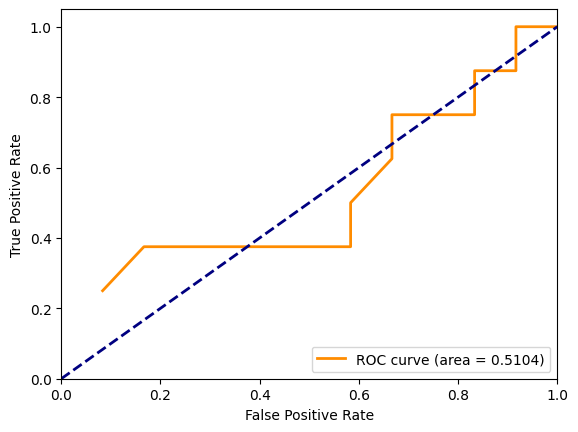

<Figure size 640x480 with 0 Axes>

In [47]:
from src.pysindy_gradiet_estimation import process_coefficient_matrix

feature_biological_names = ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"]

threshold_scan = np.linspace(0.0, 0.1, 100)
fprs, tprs = [], []
dt = 10  # min
for i, threshold in enumerate(threshold_scan):
    print(f'threshold {threshold}\n')
    optimizer = ps.STLSQ(threshold=threshold)
    model_threshold = ps.SINDy(optimizer=optimizer, feature_library=library)
    model_threshold.fit(x_train_multi, t=dt, multiple_trajectories=True)
    print(f'=== done fitting.')
    coefficient_matrix = process_coefficient_matrix(model_threshold.coefficients(), feature_biological_names,
                                                    library.get_feature_names())
    fpr, tpr = calculate_confusion_matrix_from_model(coefficient_matrix, compare_aginst_switch_off_sereies=False,
                                                     consider_inhibition=False, undirected_model=False, return_fps_tps=True)
    fprs.append(fpr)
    tprs.append(tpr)

roc_auc = auc(sorted(fprs), sorted(tprs))
plot_roc(sorted(fprs), sorted(tprs), roc_auc, "figures/pysingdy.png")
# plot_roc_simplified(fprs, tprs)

In [48]:
tprs

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.875,
 0.875,
 0.875,
 0.875,
 0.875,
 0.875,
 0.875,
 0.875,
 0.875,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.625,
 0.5,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.5,
 0.5,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.375,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25]

In [49]:
thresholds

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])